# Demonstration of loading subset from large dat file with neo RawIO

https://neo.readthedocs.io/en/stable/rawio.html

neo.rawio is a low-level layer for reading data only. Reading consists of getting NumPy buffers (often int16/int64) of signals/spikes/events.


## Import neuroscoperawio 

https://github.com/NeuralEnsemble/python-neo/blob/master/neo/rawio/neuroscoperawio.py

and other helpful packages

In [1]:
from neo.rawio import neuroscoperawio

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## helper function to read xml channels and groups

we need this because neuroscoperawio does not preserve or store the channel order as far as I know

In [2]:
from xml.etree import ElementTree
def parse_xml_channel_groups(filename):
    filename = filename.replace('.xml', '').replace('.dat', '')

    tree = ElementTree.parse(filename + '.xml')
    root = tree.getroot()

    # find channels
    channel_group = []
    for grp_index, xml_chx in enumerate(
            root.find('anatomicalDescription').find('channelGroups').findall('group')):
        for xml_rc in xml_chx:
            channel_group.append([int(xml_rc.text),grp_index])
    return np.array(channel_group)

## First create a reader from class neuroscoperawio

In [3]:
reader = neuroscoperawio.NeuroScopeRawIO('Z:/Data/HMC1/day8/day8')
reader

NeuroScopeRawIO: Z:/Data/HMC1/day8/day8

## Then browse the internal header and display information:

In [4]:
reader.parse_header()
print(reader)

NeuroScopeRawIO: Z:/Data/HMC1/day8/day8
nb_block: 1
nb_segment:  [1]
signal_streams: [Signals (chans: 512)]
signal_channels: [ch0grp0, ch1grp0, ch2grp0, ch3grp0 ... ch508grp15 , ch509grp15 , ch510grp15 , ch511grp15]
spike_channels: []
event_channels: []



### You get the number of blocks and segments per block. You have information about channels: signal_channels, spike_channels, event_channels.

All this information is internally available in the header dict:

In [5]:
reader.header.keys()

dict_keys(['nb_block', 'nb_segment', 'signal_streams', 'signal_channels', 'spike_channels', 'event_channels'])

### You can convert signal channel info to pandas data frame for ease 

In [6]:
df = pd.DataFrame.from_dict(reader.header['signal_channels'])
df.head()

,name,id,sampling_rate,dtype,units,gain,offset,stream_id
0,ch0grp0,0,20000.0,int16,mV,3.051758e-10,0.0,0
1,ch1grp0,1,20000.0,int16,mV,3.051758e-10,0.0,0
2,ch2grp0,2,20000.0,int16,mV,3.051758e-10,0.0,0
3,ch3grp0,3,20000.0,int16,mV,3.051758e-10,0.0,0
4,ch4grp0,4,20000.0,int16,mV,3.051758e-10,0.0,0


## Finally, lets load and plot some data

### find channels from shank 9

Using helper 'parse_xml_channel_groups' as unsure if neo stores channel order


In [7]:
channel_group = parse_xml_channel_groups(reader.filename)
shank = 9
channel_indexes = channel_group[channel_group[:,1] == shank,0]

### Get signal from shank 9 channels around sharp wave ripple

In [8]:
# epoch of time around ripple, which was previously found
seconds_idx = np.array([7.320,7.620])
# convert to index
to_idx = (seconds_idx*reader.get_signal_sampling_rate()).astype(int)
# get chunk of data
raw_sigs = reader.get_analogsignal_chunk(i_start=to_idx[0],
                                        i_stop=to_idx[1],
                                        channel_indexes=channel_indexes)

### finally plot data

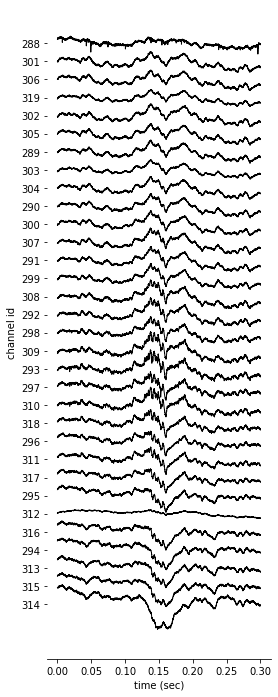

In [9]:
plt.figure(figsize=(4,12))
channel_offset = -np.arange(raw_sigs.shape[1])*4500
x = np.arange(raw_sigs.shape[0]) / reader.get_signal_sampling_rate()
plt.plot(x,raw_sigs + channel_offset,color='k',linewidth=1)
ax = plt.gca()
ax.set_yticks(channel_offset)
ax.set_yticklabels(channel_indexes)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.xlabel('time (sec)')
plt.ylabel('channel id')
plt.show()